Michael Fouts  
CHE 625  
March 1, 2023

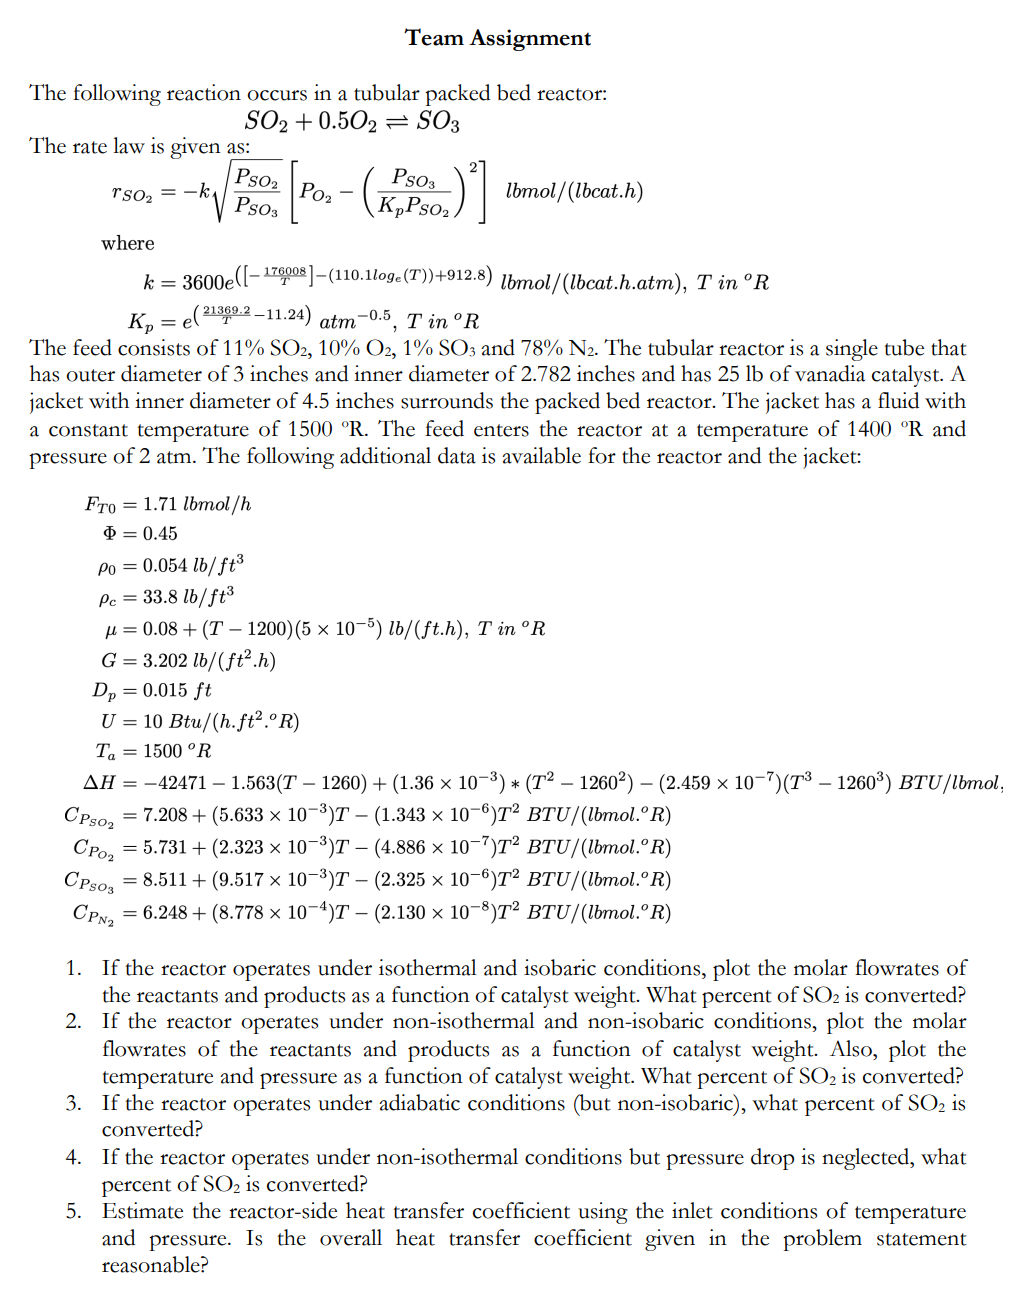

# Question 1

a) If the reactor operates under isothermal and isobaric conditions, plot the molar flowrates of the reactants and products as a function of catalyst weight.

b) What percent of SO2 is converted?

For this, we can employ a similar approach to last homework where we perform a material balance for each species, write those in a function and use solve_ivp to integrate along the length of the reactor.  Below are the written material balances.

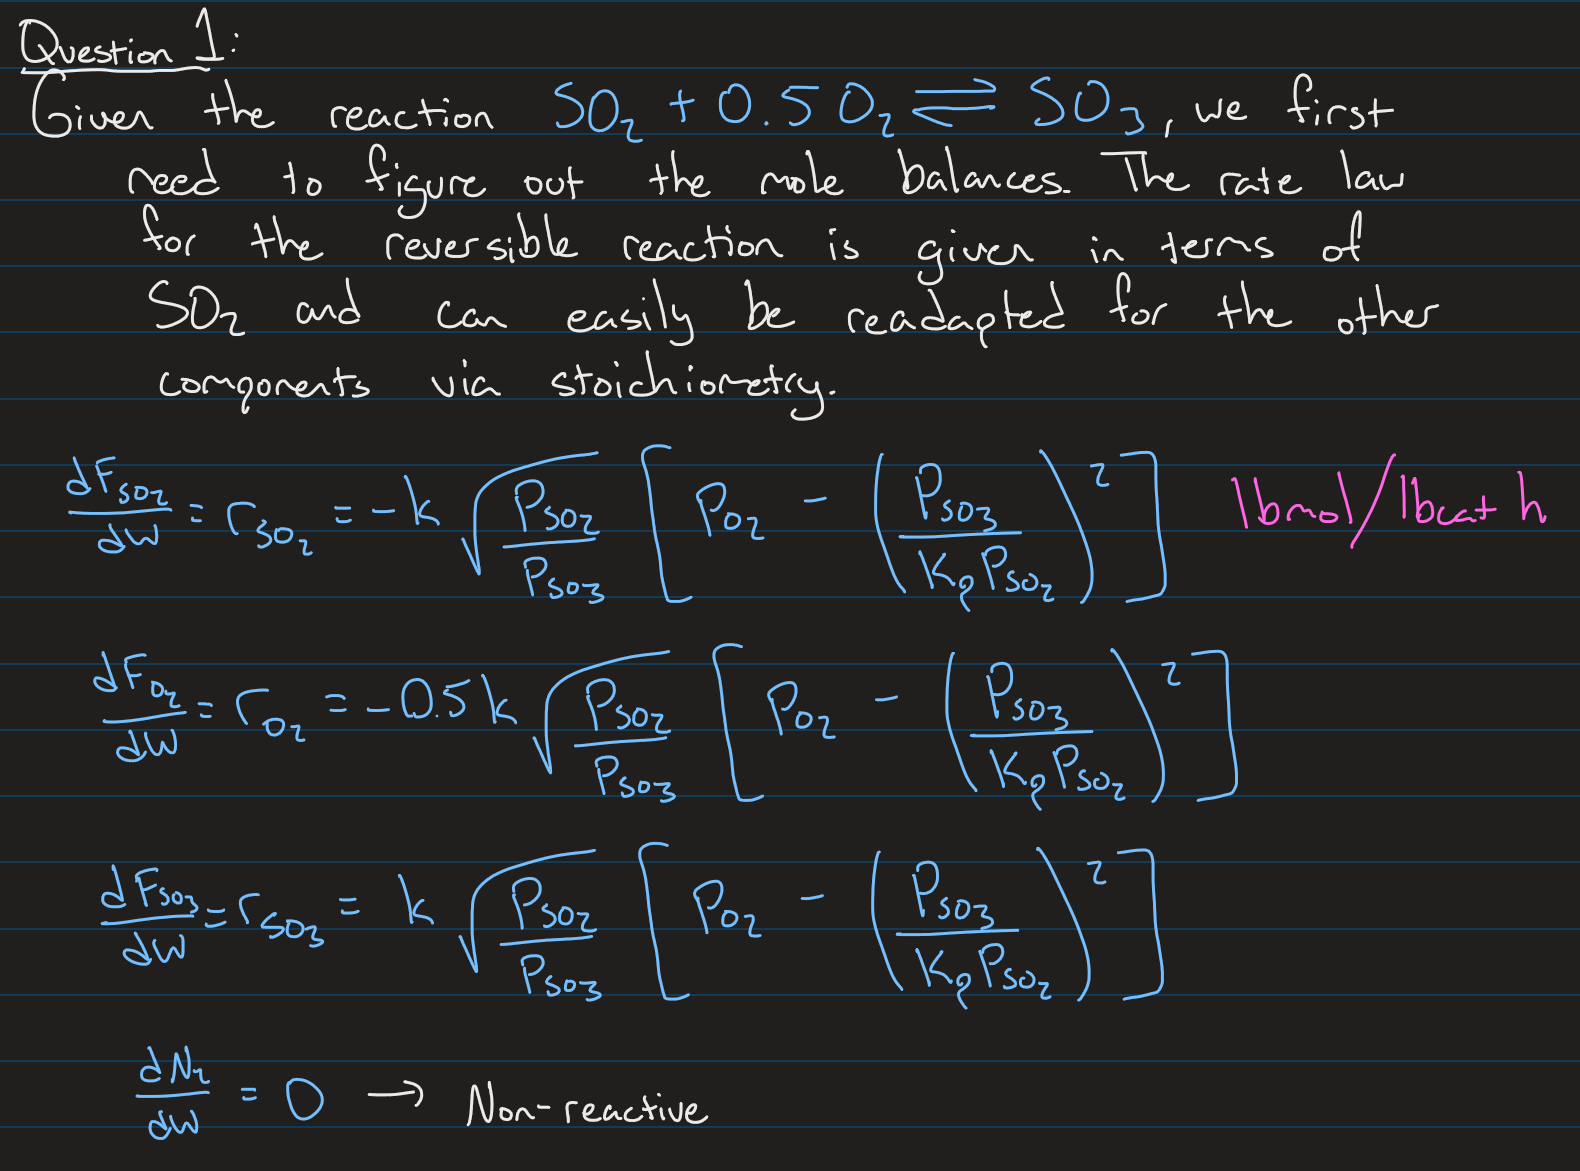

In [128]:
# Import relevant libraries

# For data processing
import math
import pandas as pd
import numpy as np

# For integration
from scipy.integrate import solve_ivp

# For visualizations
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [129]:
def dW(w,variables):
    '''
    This function takes in a weight as an independent variable and
    a list called changes as dependent variables and returns the
    incremental changes of the functions simulating the changing
    elements down the length of the reactor bed.
    '''
    # Define constants here, but variables that will change later
    T = 1400 # °R
    P = 2 # atm

    # Create aggrgate variables
    Ft = (variables[0] + variables[1] + variables [2] + variables[3])

    # Define other variables
    k = 3600*math.exp((-176008/T) - (110.1*math.log(T)) + 912.8) #lbmol/(lbcat h atm)
    Kp = math.exp((21369.2/T) - 11.24) # atm^-0.5
    Pso2 = P*(variables[0]/Ft)
    Po2 = P*(variables[1]/Ft)
    Pso3 = P*(variables[2]/Ft)

    # Reference for variables list
    # variables[0] = Fso2 in lbmol/hr
    # variables[1] = Fo2 in lbmol/hr
    # variables[2] = Fso3 in lbmol/hr
    # variables[3] = Fn2 in lbmol/hr

    # Change Equations
    dFso2 = -k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFo2 = -0.5*k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFso3 = k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFn2 = 0

    return [dFso2, dFo2, dFso3, dFn2]

In [130]:
# min and max weight for integration
weight_span = [0, 25]
# weight_series specifies what weights to give results for each variable.
# Because of indexing in python starting at 0, you have to add a 1 to the
# max weight here.
weight_series = np.arange(0,25+0.1,0.1)
Fto = 1.71 # lbmol/h

solution = solve_ivp(dW, #function
                     weight_span, #min and max weight for integration
                     [0.11*Fto, 0.10*Fto, 0.01*Fto, 0.78*Fto], # initial conditions (Ethylene, Oxygen, EO, Pressure)
                     t_eval = weight_series,
                     method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

In [131]:
results = pd.DataFrame(solution.y.transpose())
results = pd.concat([pd.DataFrame(weight_series), results], axis=1)
results.columns = ['Weight','SO2','Oxygen','SO3','N2']
# results

Ploting the results to answer part a of the question.  I've chosen to do both with and withouth N2 for a better representation.

[]

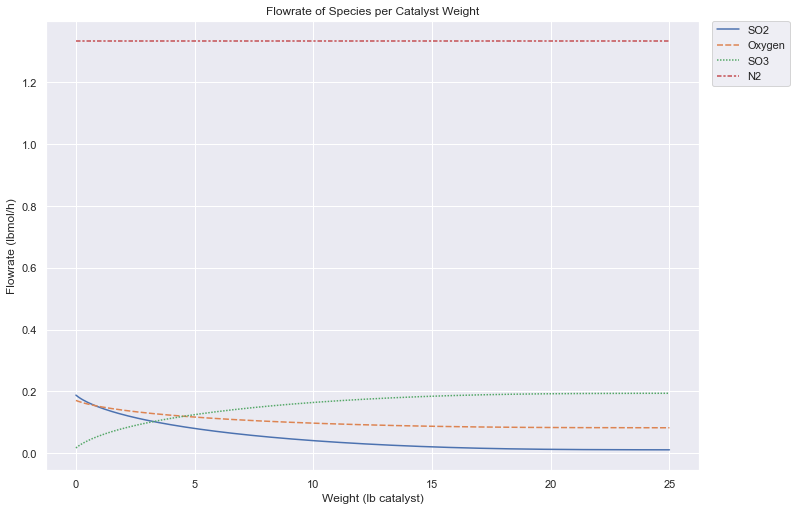

In [132]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = df_to_plot, 
                      x = 'Weight', 
                      y = 'Value', 
                      style = 'Variable', 
                      hue = 'Variable')
plt.set(xlabel = 'Weight (lb catalyst)',
        ylabel = 'Flowrate (lbmol/h)',
        title = 'Flowrate of Species per Catalyst Weight')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.plot()

[]

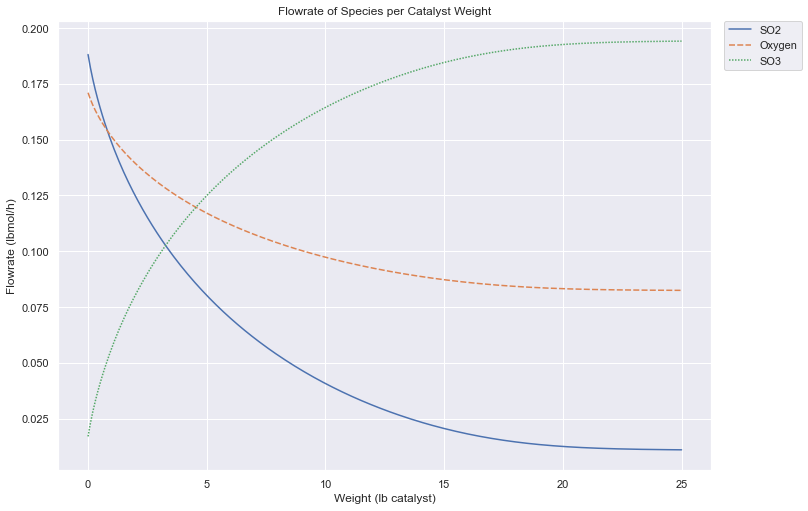

In [133]:
plt = sns.lineplot(data = df_to_plot[df_to_plot['Variable'] != 'N2'], 
                      x = 'Weight', 
                      y = 'Value', 
                      style = 'Variable', 
                      hue = 'Variable')
plt.set(xlabel = 'Weight (lb catalyst)',
        ylabel = 'Flowrate (lbmol/h)',
        title = 'Flowrate of Species per Catalyst Weight')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.plot()

In [134]:
conversion = (results['SO2'][0]-results['SO2'].tail(1).item())/results['SO2'][0]*100
print('The conversion is', round(conversion,2), '%')

The conversion is 94.1 %


# Question 2

a) If the reactor operates under non-isothermal and non-isobaric conditions, plot the molar flowrates of the reactants and products as a function of catalyst weight.  Also, plot the temperature and pressure as a function of catalyst weight.

b) What percent of SO2 is converted?

This requires two additional differential equations to add to our reactor, one for the change in pressure and one for the change in temperature along the weight of the reactor.  Below is the written out derivation of these equations.

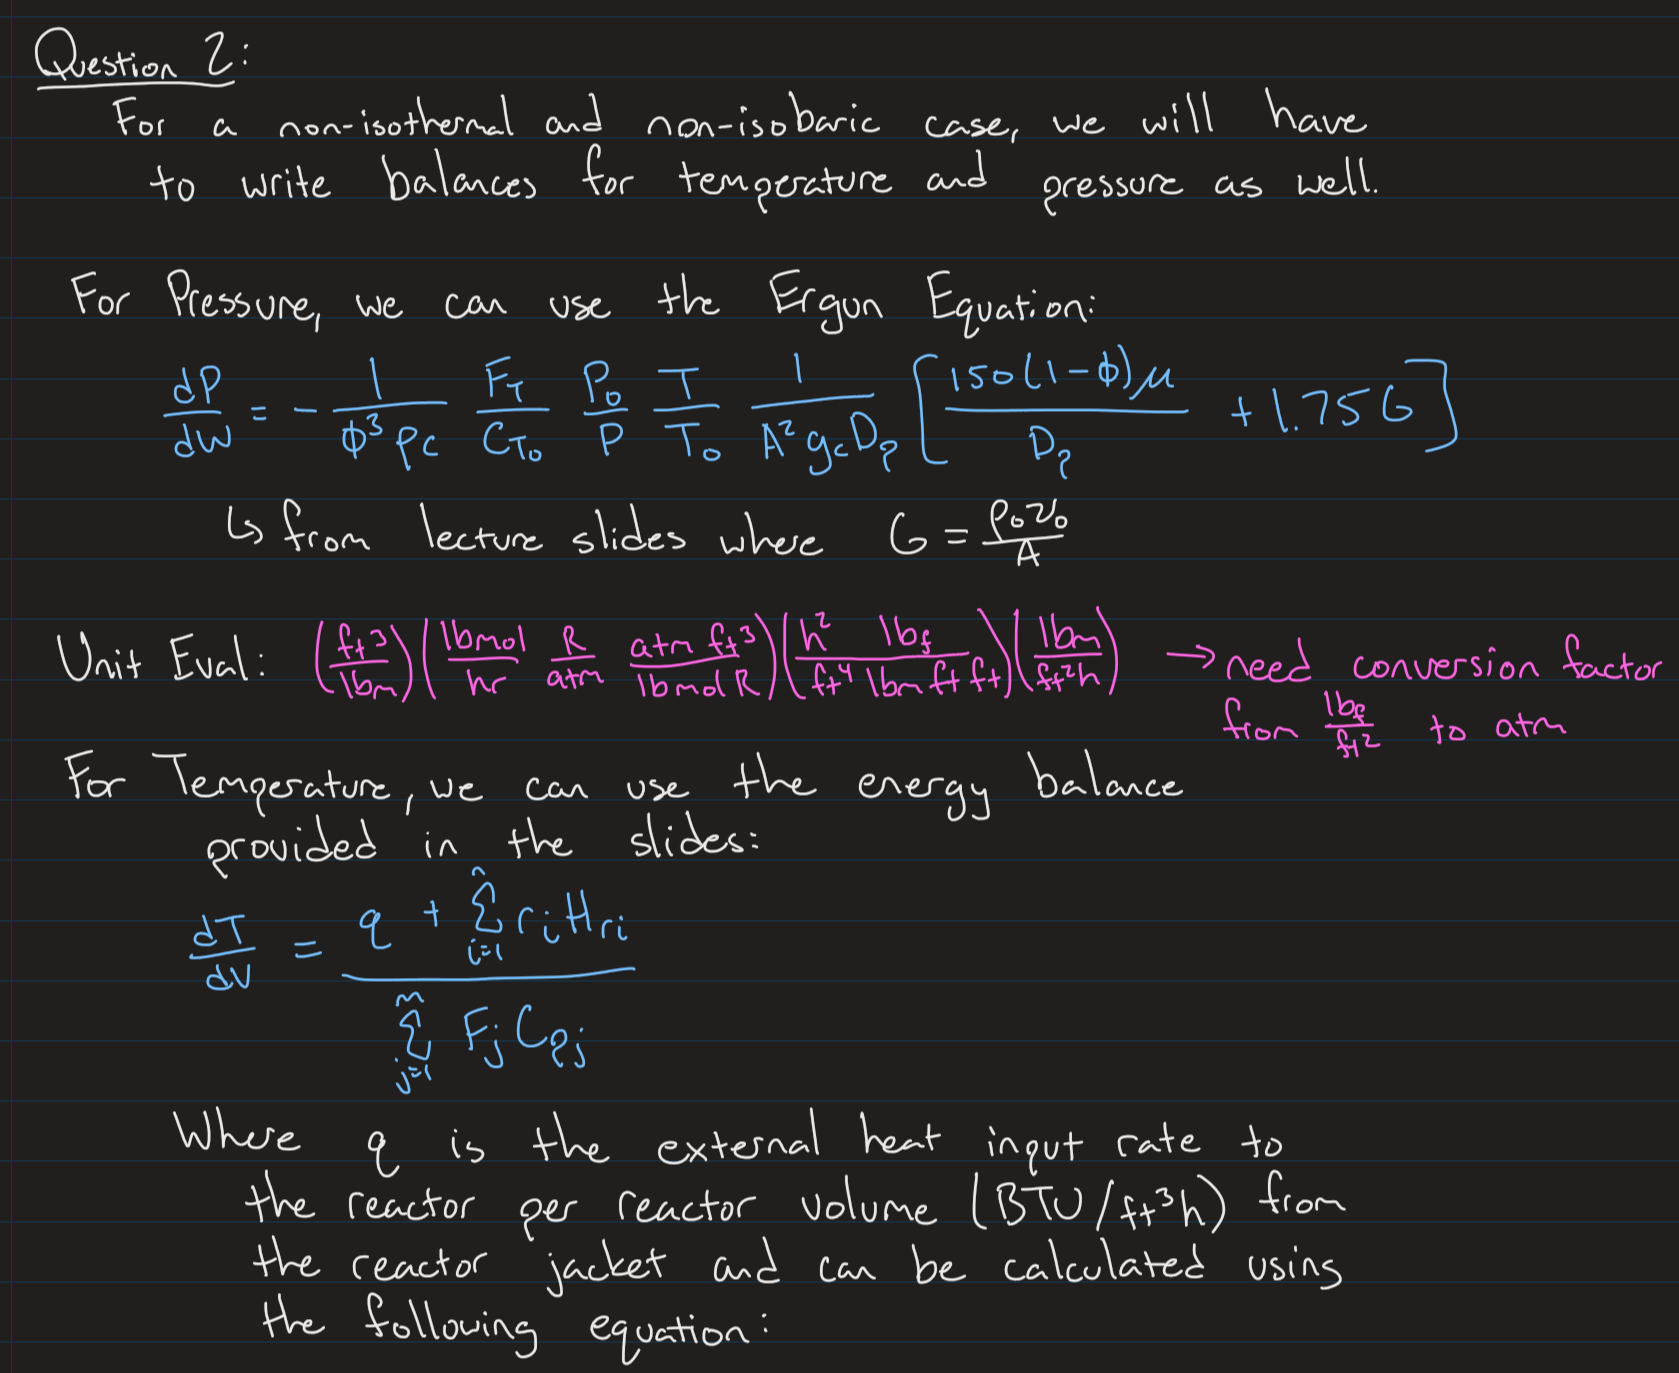

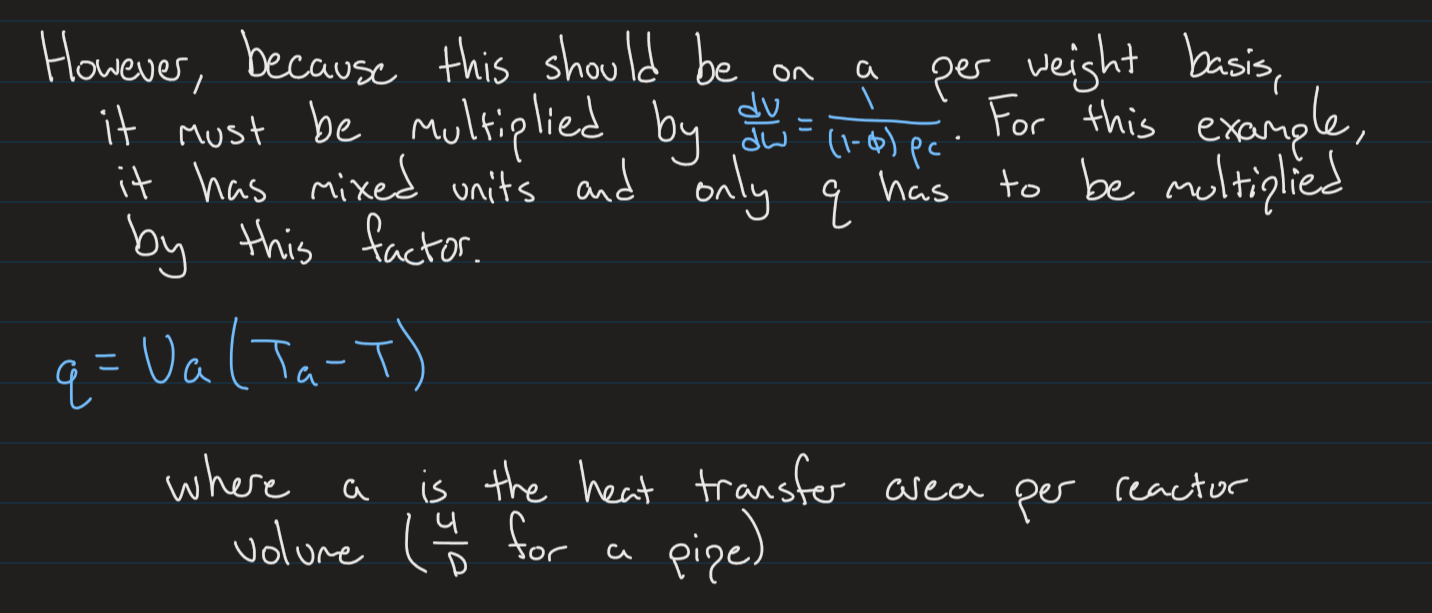

In [135]:
def dW(w,variables):
    '''
    This function takes in a weight as an independent variable and
    a list called changes as dependent variables and returns the
    incremental changes of the functions simulating the changing
    elements down the length of the reactor bed.
    '''
    # Create aggrgate variables
    Ft = (variables[0] + variables[1] + variables [2] + variables[3])

    # Define other variables
    T = variables[5] # °R
    P = variables[4] # atm
    P0 = 2 # atm
    T0 = 1400 # °R
    R = 0.730240507295273 #atm ft3/ lbmol R
    k = 3600*math.exp((-176008/T) - (110.1*math.log(T)) + 912.8) #lbmol/(lbcat h atm)
    Kp = math.exp((21369.2/T) - 11.24) # atm^-0.5
    Pso2 = P*(variables[0]/Ft) # atm
    Po2 = P*(variables[1]/Ft) # atm
    Pso3 = P*(variables[2]/Ft) # atm
    pc = 33.8 #lb/ft3
    phi = 0.45 # Void Fraction
    Ct0 = P0/(T0*R) #lbmol/ft3
    A = math.pi*((2.782/12)**2)/4 # Cross Sectional Area in ft2
    Dp = 0.015 # ft
    gc = 4.17*10**8 #lbm ft / (h2 lbf)
    G = 3.202 #lbm/(h ft2)
    mu = 0.08 + (variables[5] - 1200)*(5*10**-5) #lbm/(ft h)
    del_H = (-42471 - 1.563*(variables[5] - 1260)+(1.36*10**-3)*(variables[5]**2 - 1260**2) - (2.459*10**-7)*(variables[5]**-7)*(variables[5]**3 - 1260**3)) #BTU/ lbmol
    Cpso2 = 7.208 + (5.633 * 10**-3)*variables[5] - (1.343 * 10**-6)*variables[5]**2 # BTU/(lbmol °R)
    Cpo2 = 5.731 + (2.323 * 10**-3)*variables[5] - (4.886 * 10**-7)*variables[5]**2 # BTU/(lbmol °R)
    Cpso3 = 8.511 + (9.517 * 10**-3)*variables[5] - (2.325 * 10**-6)*variables[5]**2 # BTU/(lbmol °R)
    Cpn2 = 6.248 + (8.778 * 10**-4)*variables[5] - (2.130 * 10**-8)*variables[5]**2 # BTU/(lbmol °R)
    U = 10 # BTU/h ft2 °R
    a = 4/(2.782/12) # 1/ ft
    Ta = 1500 # °R
    q = U *a*(Ta - variables[5])*(1/((1-phi)*pc)) # BTU/h lbm

    # Reference for variables list
    # variables[0] = Fso2 in lbmol/hr
    # variables[1] = Fo2 in lbmol/hr
    # variables[2] = Fso3 in lbmol/hr
    # variables[3] = Fn2 in lbmol/hr
    # variables[4] = P in atm
    # variables[5] = T in °R

    # Change Equations
    dFso2 = -k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFo2 = -0.5*k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFso3 = k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFn2 = 0
    dP = -(1/(pc*(phi**3)))*(Ft/Ct0)*(P0/variables[4])*(variables[5]/T0)*(1/((A**2)*gc*Dp))*(((150*(1-phi)*mu)/Dp)+(1.75*G)) * 0.000473
    dT = (q + (dFso2*del_H))/(variables[0]*Cpso2 + variables[1]*Cpo2 + variables[2]*Cpso3 + variables[3]*Cpn2)

    return [dFso2, dFo2, dFso3, dFn2, dP, dT]

In [136]:
# min and max weight for integration
weight_span = [0, 25]
# weight_series specifies what weights to give results for each variable.
# Because of indexing in python starting at 0, you have to add a 1 to the
# max weight here.
weight_series = np.arange(0,25+0.1,0.1)
Fto = 1.71 # lbmol/h

solution = solve_ivp(dW, #function
                     weight_span, #min and max weight for integration
                     [0.11*Fto, 0.10*Fto, 0.01*Fto, 0.78*Fto, 2, 1400], # initial conditions (Ethylene, Oxygen, EO, Pressure)
                     t_eval = weight_series,
                     method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

In [137]:
results = pd.DataFrame(solution.y.transpose())
results = pd.concat([pd.DataFrame(weight_series), results], axis=1)
results.columns = ['Weight','SO2','Oxygen','SO3','N2', 'Pressure', 'Temperature']
# results

[]

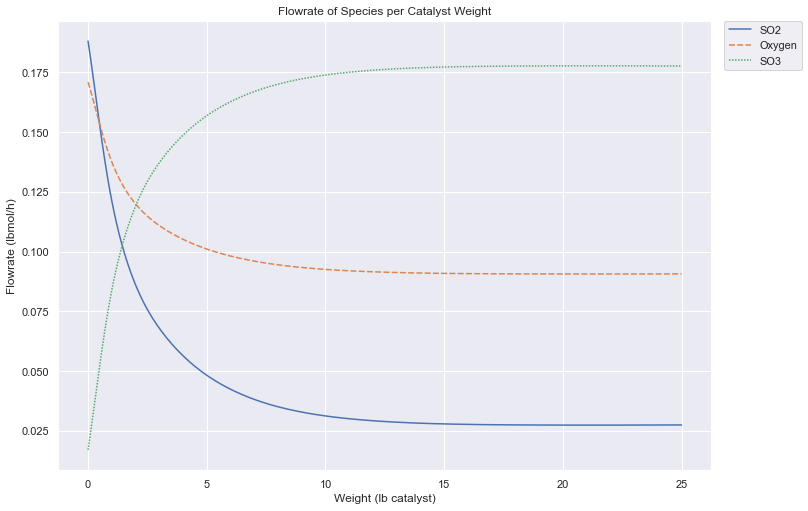

In [138]:
df_to_plot = pd.melt(frame = results.drop(['Pressure', 'Temperature', 'N2'], axis = 1),
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = df_to_plot, 
                      x = 'Weight', 
                      y = 'Value', 
                      style = 'Variable', 
                      hue = 'Variable')
plt.set(xlabel = 'Weight (lb catalyst)',
        ylabel = 'Flowrate (lbmol/h)',
        title = 'Flowrate of Species per Catalyst Weight')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.plot()

[]

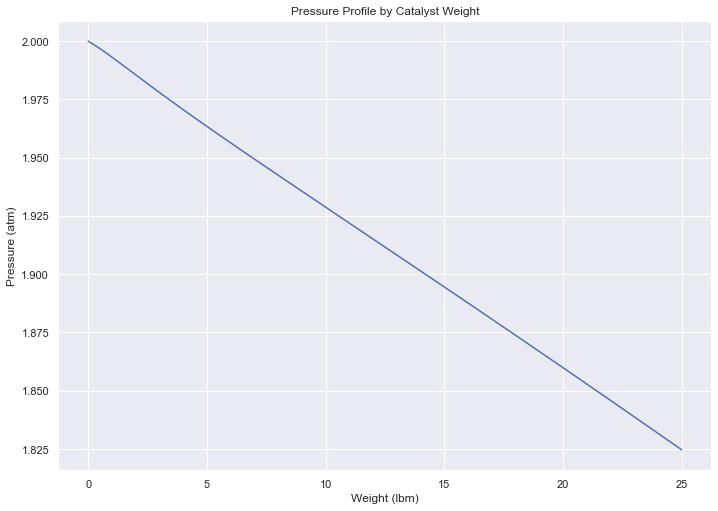

In [139]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = results, x = 'Weight', y = 'Pressure')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Pressure (atm)',
        title = 'Pressure Profile by Catalyst Weight')
plt.plot()

[]

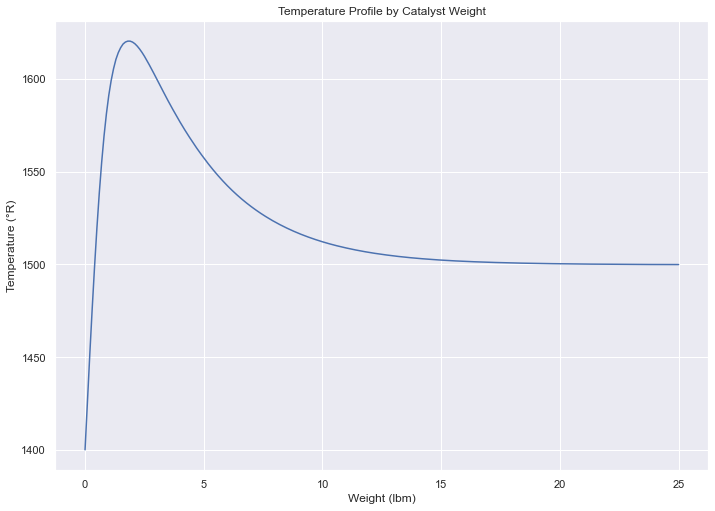

In [140]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = results, x = 'Weight', y = 'Temperature')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Temperature (°R)',
        title = 'Temperature Profile by Catalyst Weight')
plt.plot()

In [141]:
conversion = (results['SO2'][0]-results['SO2'].tail(1).item())/results['SO2'][0]*100
print('The conversion is', round(conversion,2), '%')

The conversion is 85.38 %


# Question 3

If the reactor operates under adiabatic conditions (but non-isobaric), what percent of SO2 is converted?

For this example, adiabatic means that there is no energy given from the jacket to the reactor and this is easily implemented by setting q equal to 0 in the energy balance and using the same code as in part 2.

In [142]:
def dW(w,variables):
    '''
    This function takes in a weight as an independent variable and
    a list called changes as dependent variables and returns the
    incremental changes of the functions simulating the changing
    elements down the length of the reactor bed. This function
    is specific to ethylene and oxygen being turned into 
    ethylene oxide. 
    '''
    # Create aggrgate variables
    Ft = (variables[0] + variables[1] + variables [2] + variables[3])

    # Define other variables
    T = variables[5] # °R
    P = variables[4] # atm
    P0 = 2 # atm
    T0 = 1400 # °R
    R = 0.730240507295273 #atm ft3/ lbmol R
    k = 3600*math.exp((-176008/T) - (110.1*math.log(T)) + 912.8) #lbmol/(lbcat h atm)
    Kp = math.exp((21369.2/T) - 11.24) # atm^-0.5
    Pso2 = P*(variables[0]/Ft) # atm
    Po2 = P*(variables[1]/Ft) # atm
    Pso3 = P*(variables[2]/Ft) # atm
    pc = 33.8 #lb/ft3
    phi = 0.45 # Void Fraction
    Ct0 = P0/(T0*R) #lbmol/ft3
    A = math.pi*((2.782/12)**2)/4 # Cross Sectional Area in ft2
    Dp = 0.015 # ft
    gc = 4.17*10**8 #lbm ft / (h2 lbf)
    G = 3.202 #lbm/(h ft2)
    mu = 0.08 + (variables[5] - 1200)*(5*10**-5) #lbm/(ft h)
    del_H = (-42471 - 1.563*(variables[5] - 1260)+(1.36*10**-3)*(variables[5]**2 - 1260**2) - (2.459*10**-7)*(variables[5]**-7)*(variables[5]**3 - 1260**3))
    Cpso2 = 7.208 + (5.633 * 10**-3)*variables[5] - (1.343 * 10**-6)*variables[5]**2
    Cpo2 = 5.731 + (2.323 * 10**-3)*variables[5] - (4.886 * 10**-7)*variables[5]**2
    Cpso3 = 8.511 + (9.517 * 10**-3)*variables[5] - (2.325 * 10**-6)*variables[5]**2
    Cpn2 = 6.248 + (8.778 * 10**-4)*variables[5] - (2.130 * 10**-8)*variables[5]**2
    U = 10 # BTU/h ft2 °R
    a = 4/(2.782/12) # 1/ ft
    Ta = 1500 # °R
    q = 0 # Adiabatic

    # Reference for variables list
    # variables[0] = Fso2 in lbmol/hr
    # variables[1] = Fo2 in lbmol/hr
    # variables[2] = Fso3 in lbmol/hr
    # variables[3] = Fn2 in lbmol/hr
    # variables[4] = P in atm
    # variables[5] = T in °R

    # Change Equations
    dFso2 = -k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFo2 = -0.5*k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFso3 = k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFn2 = 0
    dP = -(1/(pc*(phi**3)))*(Ft/Ct0)*(P0/variables[4])*(variables[5]/T0)*(1/((A**2)*gc*Dp))*(((150*(1-phi)*mu)/Dp)+(1.75*G)) * 0.000473
    dT = (q + (dFso2*del_H))/(variables[0]*Cpso2 + variables[1]*Cpo2 + variables[2]*Cpso3 + variables[3]*Cpn2)

    return [dFso2, dFo2, dFso3, dFn2, dP, dT]

In [143]:
# min and max weight for integration
weight_span = [0, 25]
# weight_series specifies what weights to give results for each variable.
# Because of indexing in python starting at 0, you have to add a 1 to the
# max weight here.
weight_series = np.arange(0,25+0.1,0.1)
Fto = 1.71 # lbmol/h

solution = solve_ivp(dW, #function
                     weight_span, #min and max weight for integration
                     [0.11*Fto, 0.10*Fto, 0.01*Fto, 0.78*Fto, 2, 1400], # initial conditions (Ethylene, Oxygen, EO, Pressure)
                     t_eval = weight_series,
                     method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

In [144]:
results = pd.DataFrame(solution.y.transpose())
results = pd.concat([pd.DataFrame(weight_series), results], axis=1)
results.columns = ['Weight','SO2','Oxygen','SO3','N2', 'Pressure', 'Temperature']
# results

[]

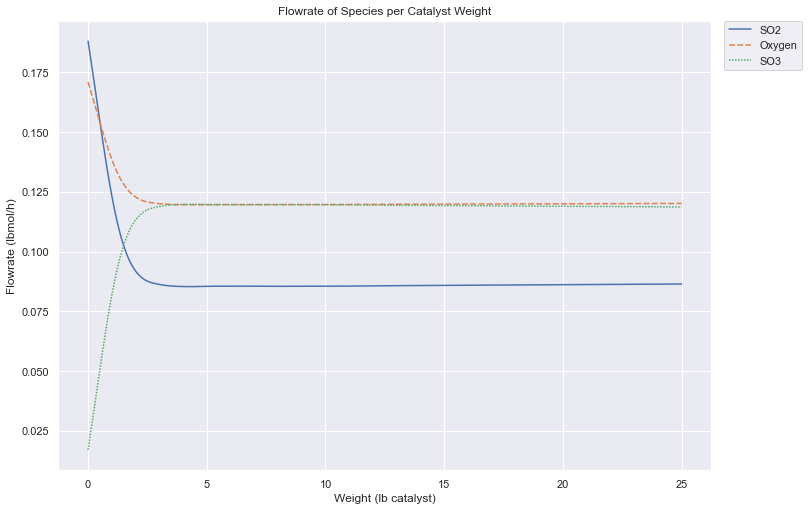

In [145]:
df_to_plot = pd.melt(frame = results.drop(['Pressure', 'Temperature', 'N2'], axis = 1),
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = df_to_plot, 
                      x = 'Weight', 
                      y = 'Value', 
                      style = 'Variable', 
                      hue = 'Variable')
plt.set(xlabel = 'Weight (lb catalyst)',
        ylabel = 'Flowrate (lbmol/h)',
        title = 'Flowrate of Species per Catalyst Weight')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.plot()

[]

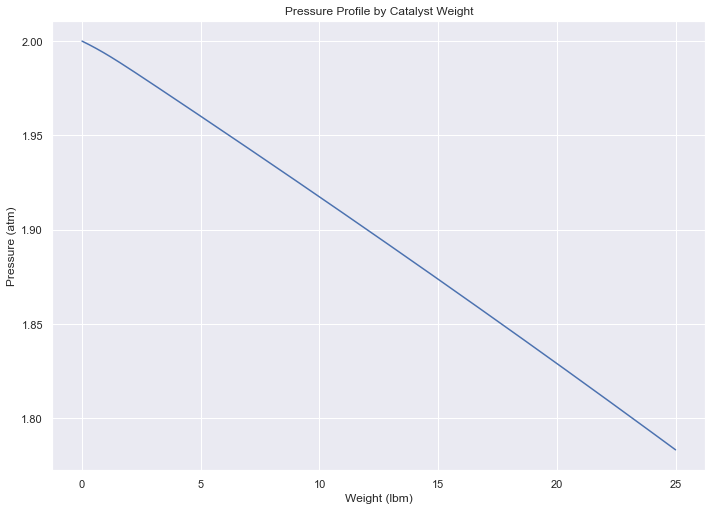

In [146]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = results, x = 'Weight', y = 'Pressure')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Pressure (atm)',
        title = 'Pressure Profile by Catalyst Weight')
plt.plot()

[]

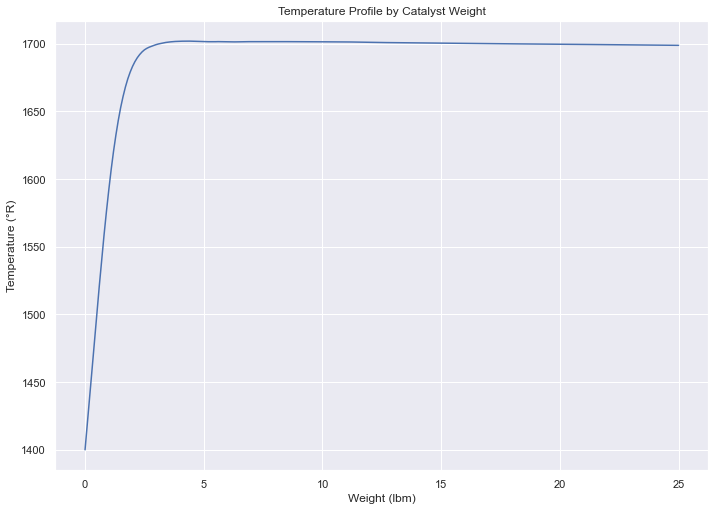

In [147]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = results, x = 'Weight', y = 'Temperature')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Temperature (°R)',
        title = 'Temperature Profile by Catalyst Weight')
plt.plot()

In [148]:
conversion = (results['SO2'][0]-results['SO2'].tail(1).item())/results['SO2'][0]*100
print('The conversion is', round(conversion,2), '%')

The conversion is 54.03 %


# Question 4

If the reactor operates under non-isothermal conditions but pressure drop is neglected, what percent of SO2 is converted?

For this, we can set the differential equation of Pressure can be set to 0 since pressure doesn't change.  As far as non-isothermal, assuming it is non-adiabatic, we can use the same energy balance as in question 2.

In [149]:
def dW(w,variables):
    '''
    This function takes in a weight as an independent variable and
    a list called changes as dependent variables and returns the
    incremental changes of the functions simulating the changing
    elements down the length of the reactor bed. This function
    is specific to ethylene and oxygen being turned into 
    ethylene oxide. 
    '''
    # Create aggrgate variables
    Ft = (variables[0] + variables[1] + variables [2] + variables[3])

    # Define other variables
    T = variables[5] # °R
    P = variables[4] # atm
    P0 = 2 # atm
    T0 = 1400 # °R
    R = 0.730240507295273 #atm ft3/ lbmol R
    k = 3600*math.exp((-176008/T) - (110.1*math.log(T)) + 912.8) #lbmol/(lbcat h atm)
    Kp = math.exp((21369.2/T) - 11.24) # atm^-0.5
    Pso2 = P*(variables[0]/Ft) # atm
    Po2 = P*(variables[1]/Ft) # atm
    Pso3 = P*(variables[2]/Ft) # atm
    pc = 33.8 #lb/ft3
    phi = 0.45 # Void Fraction
    Ct0 = P0/(T0*R) #lbmol/ft3
    A = math.pi*((2.782/12)**2)/4 # Cross Sectional Area in ft2
    Dp = 0.015 # ft
    gc = 4.17*10**8 #lbm ft / (h2 lbf)
    G = 3.202 #lbm/(h ft2)
    mu = 0.08 + (variables[5] - 1200)*(5*10**-5) #lbm/(ft h)
    del_H = (-42471 - 1.563*(variables[5] - 1260)+(1.36*10**-3)*(variables[5]**2 - 1260**2) - (2.459*10**-7)*(variables[5]**-7)*(variables[5]**3 - 1260**3))
    Cpso2 = 7.208 + (5.633 * 10**-3)*variables[5] - (1.343 * 10**-6)*variables[5]**2
    Cpo2 = 5.731 + (2.323 * 10**-3)*variables[5] - (4.886 * 10**-7)*variables[5]**2
    Cpso3 = 8.511 + (9.517 * 10**-3)*variables[5] - (2.325 * 10**-6)*variables[5]**2
    Cpn2 = 6.248 + (8.778 * 10**-4)*variables[5] - (2.130 * 10**-8)*variables[5]**2
    U = 10 # BTU/h ft2 °R
    a = 4/(2.782/12) # 1/ ft
    Ta = 1500 # °R
    q = U *a*(Ta - variables[5])*(1/((1-phi)*pc)) # BTU/h lbm

    # Reference for variables list
    # variables[0] = Fso2 in lbmol/hr
    # variables[1] = Fo2 in lbmol/hr
    # variables[2] = Fso3 in lbmol/hr
    # variables[3] = Fn2 in lbmol/hr
    # variables[4] = P in atm
    # variables[5] = T in °R

    # Change Equations
    dFso2 = -k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFo2 = -0.5*k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFso3 = k*((Pso2/Pso3)**0.5)*(Po2 - (Pso3/(Kp*Pso2))**2)
    dFn2 = 0
    dP = 0 # pressure drop neglected
    dT = (q + (dFso2*del_H))/(variables[0]*Cpso2 + variables[1]*Cpo2 + variables[2]*Cpso3 + variables[3]*Cpn2)

    return [dFso2, dFo2, dFso3, dFn2, dP, dT]

In [150]:
# min and max weight for integration
weight_span = [0, 25]
# weight_series specifies what weights to give results for each variable.
# Because of indexing in python starting at 0, you have to add a 1 to the
# max weight here.
weight_series = np.arange(0,25+0.1,0.1)
Fto = 1.71 # lbmol/h

solution = solve_ivp(dW, #function
                     weight_span, #min and max weight for integration
                     [0.11*Fto, 0.10*Fto, 0.01*Fto, 0.78*Fto, 2, 1400], # initial conditions (Ethylene, Oxygen, EO, Pressure)
                     t_eval = weight_series,
                     method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

In [151]:
results = pd.DataFrame(solution.y.transpose())
results = pd.concat([pd.DataFrame(weight_series), results], axis=1)
results.columns = ['Weight','SO2','Oxygen','SO3','N2', 'Pressure', 'Temperature']
# results

[]

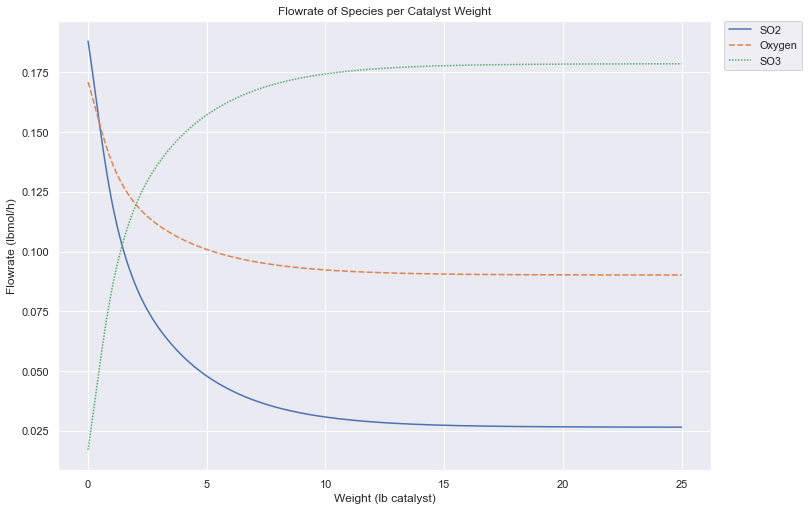

In [152]:
df_to_plot = pd.melt(frame = results.drop(['Pressure', 'Temperature', 'N2'], axis = 1),
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = df_to_plot, 
                      x = 'Weight', 
                      y = 'Value', 
                      style = 'Variable', 
                      hue = 'Variable')
plt.set(xlabel = 'Weight (lb catalyst)',
        ylabel = 'Flowrate (lbmol/h)',
        title = 'Flowrate of Species per Catalyst Weight')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.plot()

[]

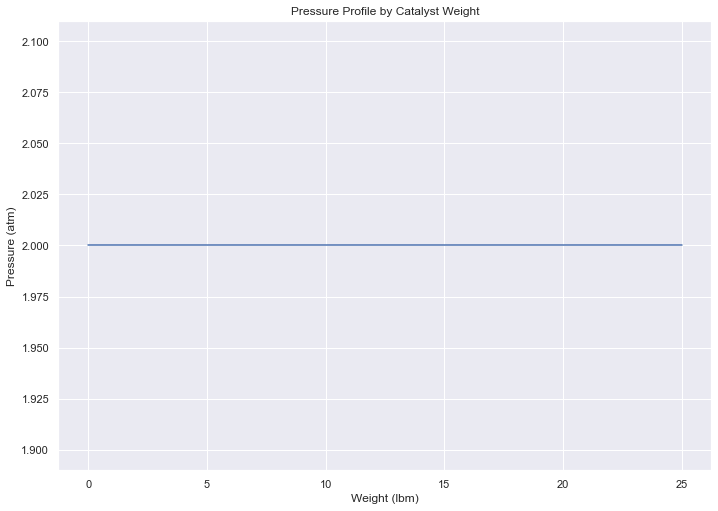

In [153]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = results, x = 'Weight', y = 'Pressure')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Pressure (atm)',
        title = 'Pressure Profile by Catalyst Weight')
plt.plot()

[]

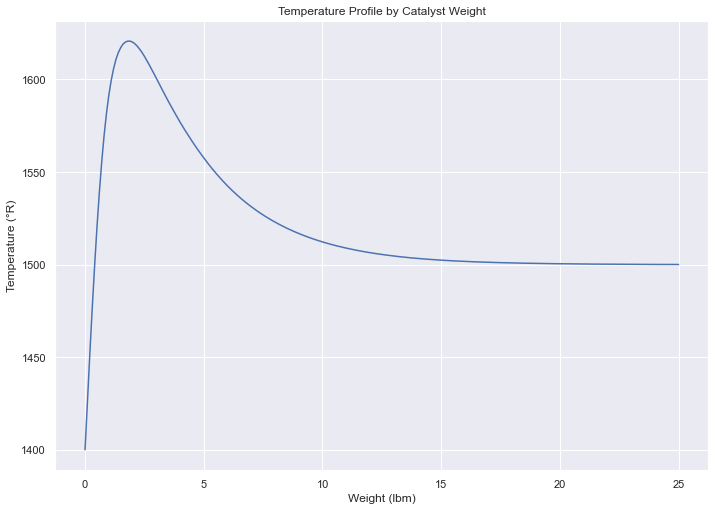

In [154]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = results, x = 'Weight', y = 'Temperature')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Temperature (°R)',
        title = 'Temperature Profile by Catalyst Weight')
plt.plot()

In [155]:
conversion = (results['SO2'][0]-results['SO2'].tail(1).item())/results['SO2'][0]*100
print('The conversion is', round(conversion,2), '%')

The conversion is 85.87 %


# Question 5

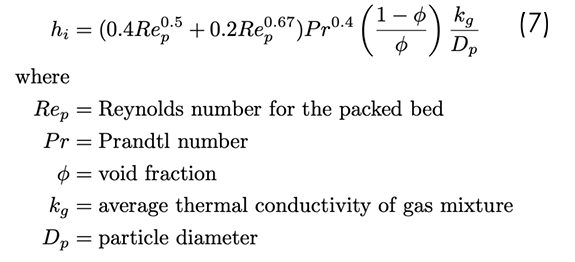

a) Estimate the reactor-side heat transfer coefficient using the inlet conditions of the temperature and pressure.

b) Is the overall heat transfer coefficient given in the problem statement resonable?

To solve the first part of the problem, we first need to calcualte the Prantyl and Reynold's numbers as shown in the two equations below.  A couple of things to note is that we are using the heat transfer equation for a packed bed where the Reyonld's number uses the particle diameter instead of the tube diameter.

$$
Pr = \frac{\mu C_p}{k}
$$

$$
Re_p = \frac{D v \rho}{\mu}
$$

In [156]:
# Reactor Side

# Define constants given
D = 0.015 #ft (particle diameter, not tube)
temp = 1400 # °R
press = 2 # atm
T = 1400 # °R

# calculate v from G
G = 3.202 # lb/ (ft2 h)
p0 = 0.054 # lb/ft3
v = G/p0 # ft/h

# Look up additional values from https://webbook.nist.gov/chemistry/fluid/
# SO2 at 945°R and 2 atm (values are not available at 1400°R so the highest
# temperature available was used.)
MW_so2 = 64.066 #lbm/lbmole
Cp_so2 = (7.208 + (5.633 * 10**-3)*T - (1.343 * 10**-6)*T**2)/MW_so2 # BTU/lbm*R
k_so2 = 0.021061*0.5781759824 # BTU/hr ft °R

# O2 at 1400°R and 2 atm
MW_o2 = 32 #lbm/lbmole
Cp_o2 = (5.731 + (2.323 * 10**-3)*T - (4.886 * 10**-7)*T**2)/MW_o2 # BTU/lbm*R
k_o2 = 0.058711*0.5781759824 # BTU/hr ft °R

# SO3 at 945°R and 2 atm (Assuming that the thermal conductivity is similar to SO2.
# Additionally, values are not available at 1400°R so the highest temperature available 
# was used.)
MW_so3 = 80.06 #lbm/lbmole
Cp_so3 = (8.511 + (9.517 * 10**-3)*T - (2.325 * 10**-6)*T**2)/MW_so3 # BTU/lbm*R
k_so3 = 0.021061*0.5781759824 # BTU/hr ft °R

# N2 at 1400°R and 2 atm
MW_n2 = 28.0134 #lbm/lbmole
Cp_n2 = (6.248 + (8.778 * 10**-4)*T - (2.130 * 10**-8)*T**2)/MW_n2 # BTU/lbm*R
k_n2 = 0.054389*0.5781759824 # BTU/hr ft °R

# Calculating the overall values (density, Cp, and k from mole average)
Cp = Cp_so2*0.11 + Cp_o2*0.10 + Cp_so3*0.01 + Cp_n2*0.78 # BTU/lbm*R
k = k_so2*0.11 + k_o2*0.10 + k_so3*0.01 + k_n2*0.78 # BTU/s ft °R

# For viscosity, let's use the equation given
mu = (0.08 + (T - 1200)*(5*10**-5)) #lbm/(ft hr)

# Prandtl Number
Pr = mu*Cp/k
print('The Prandtl Number for this scenario is:', round(Pr,3))

# Reynolds Number
Re = D*v*p0/mu
print('The Reynolds Number for this scenario is:', round(Re,2))

The Prandtl Number for this scenario is: 0.783
The Reynolds Number for this scenario is: 0.53


In [157]:
void = 0.45

hi = (0.4*Re**0.5 + 0.2*Re**0.67)*Pr**0.4*((1-void)/void)*k/D
print('The heat transfer coefficient for the reactor side is:', round(hi,5), 'BTU/h ft2 °R')

# Transform into better units
hi = hi # BTU/ (h ft2 F)

The heat transfer coefficient for the reactor side is: 0.91952 BTU/h ft2 °R


For part b, we will have to calculate a value for the outside heat transfer coefficient.

In [158]:
# Outside heat transfer coefficient, assuming the fluid is ethylene

# Define constants given
do = 4.5/12 # ft
di = 3/12 # ft
v = np.linspace(1,100) # ft/s (This is an inital guess)
press = 2 # atm
T = 1500 # °R

# Look up additional values from https://webbook.nist.gov/chemistry/fluid/
density = 0.095122 #lbm/ft3
mu = 1.0157 * 10**-5 #lbm/ft s
Cp = 0.49431 # BTU/lbm*R
k = 0.045441*0.5781759824/3600 # BTU/s ft °F

# Prandtl Number
Pr = mu*Cp/k
# print('The Prandtl Number for this scenario is:', round(Pr,3))

# Reynolds Number
Re = ((do+di)/2)*v*density/mu
# print('The Reynolds Number for this scenario is:', round(Re,0))

eta = 0
D = (di + do) / 2

part1 = (5.02/Re)*np.log10(((eta/D)/3.7) + (13/Re))
part2 = (5.02/Re)*np.log10(((eta/D)/3.7) - part1)
part3 = -2*(np.log10(((eta/D)/3.7) - part2))
f = part3**-2

# print('The friction factor using the Zigrang-Sylvester equation is:', round(f,4))

ho = (k/D)*((f/2)*(Re-1000)*Pr)/(1+12.7*((Pr**0.67)-1)*(f/2)**0.5)
# print('The heat transfer coefficient using the Gnielinki Equation is:', round(ho,5), 'BTU/s ft2 °F')
# print('The heat transfer coefficient using the Gnielinki Equation is:', round(ho*3600,2), 'BTU/h ft2 °F')

# Transform into better units
ho = ho*3600 # BTU/ (h ft2 F)

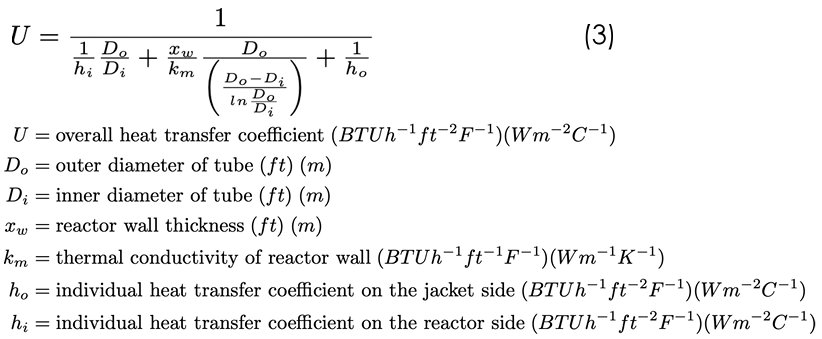

In [159]:
Do = 3/12 # ft
Di = 2.782/12 # ft
xw = Do - Di # ft
km = 24.8 # BTU / (ft h °F) (1% C Carbon Steel from Engineering Toolbox)

log_mean_D = (Do - Di)/(math.log(Do/Di))
U = ((Do/hi/Di) + (xw/km*Do/log_mean_D) + 1/ho)**-1

# print('The overall heat transfer coefficient is:', round(U,2), 'BTU/h ft2 °F')

[]

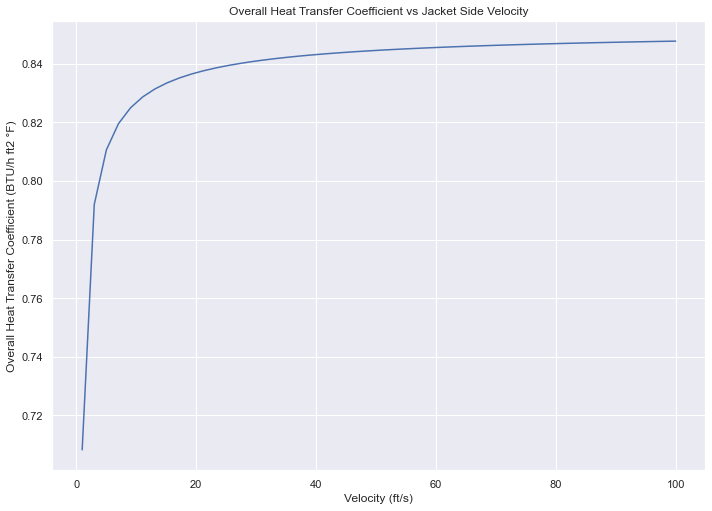

In [161]:
plt = sns.lineplot(x = v, y = U)

plt.set(xlabel = 'Velocity (ft/s)',
        ylabel = 'Overall Heat Transfer Coefficient (BTU/h ft2 °F)',
        title = 'Overall Heat Transfer Coefficient vs Jacket Side Velocity')

plt.plot()

Evaluating over a range of velocities, it looks like the value of U approaches a plateau around 0.85 BTU/h ft2 °F.  This is because hi is so low that no matter how fast the jacket side of the reactor fluid is, it will no be able to get a U of 10.